This notebook is part of the flood-detection workflow. The overall workflow is modified from Huang et al. (2015) and outlined below:
    - **Import DG image downloaded from GBDX platform
    - Convert geotiff files to numpy array via rasterio
    - Scale to surface reflectance values (divide by 10,000)
    - Define individual bands for later calculations
    - Calculate indices (NDVI, multiple versions of NDWI) and dark parameter
    - Threshold and plot based on Cloud to Street algorithm
    - Calculate MSI and MBI
    - Threshold and plot NDVI, NDWI and MSI**
    - Compare output to Cloud-to-Street results
    - Validate output based on reference data
    - Utilize SVM with inputs including flood, shadow, building, vegetation information
    
Bolded items are completed within this notebook. 

List of acronyms:
NDWI : Normalized difference water index
NDVI : Normalized difference vegetation index
MSI : Morphological shadow index
MBI : Morphological building index
SVM : Support vector machine

This notebook calculates and plots NDVI, a "dark" parameter (defined below) and several formulations of NDWI as defined within the notebook. Cloud and flood plots are produced in part based on the algorithm provided by Cloud to Street:

**Final algorithm from Cloud-to-Street for Abidjan image:**

**Clouds:** C ≥ 0.25 and RE  ≥ 0.25

**Flood:**

(NDWI1 ≥ 0.03, DARK ≤ 5, C ≤ 1, and R ≤ 0.85 ) or *check with Jeff re NDWI1 threshold. replaced with 0.03 for now

(NDWI2 ≥ 0.03, DARK ≤ 5.8, C ≤ 1)

*Note that thresholds vary slightly as this notebook was developed for pan-sharpened imagery while the original Cloud to Street algorithm was developed for non-pansharpened imagery. 

DARK = RE + NIR1 + NIR2

This notebook also calculates the MSI based on Huang et al. (2012). The calculation utilizes the scikit-image blacktop hat package. 

**References**
Huang, X., Xie, C., Fang, X., Zhang, L. (2015) Combining Pixel-and Object-Based Machine Learning for Identification of Water-Body Types from Urban High-Resolution Remote-Sensing Imagery. IEEE J. Sel. Top. Appl. Earth Obs. Remote Sens. 8, 2097–2110.

Huang, X., and Zhang, L. (2012) Morphological Building/Shadow Index for Building Extraction From High-Resolution
Imagery Over Urban Areas. IEEE J. Sel. Top. Appl. Earth Obs. Remote Sens. 5, 161-172.

Xie, C., Huang, X., Zeng, W., & Fang, X. (2016). A novel water index for urban high-resolution eight-band WorldView-2 imagery. International Journal of Digital Earth, 9(10), 925–941.

Cloud to Street. Urban Flood Mapping Using Very-High Resolution Satellite Imagery. Available at: https://abidjan.cloudtostreet.info/info

In [1]:
%matplotlib inline

In [2]:
# Import necessary packages
import os
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from glob import glob
import rasterio as rio
from rasterio.mask import mask
import earthpy as et
import earthpy.spatial as es

# Import modules with custom functions
import calc_array_mask
import morph_indices

In [3]:
# Set working directory
os.chdir(os.path.join(et.io.HOME, 'earth-analytics','spring-2019', 'flood-detection'))
os.environ["PROJ_LIB"] = r"C:\Users\katy\Anaconda3\envs\earth-analytics-python\Library\share"

### Note: update "aoi" parameter and band_path with directory name for imagery of interest

In [4]:
# Identify area of interest (aoi), set directories for inputs and outputs
aoi = "bietry_expanded_ps"

band_path = os.path.join("dg-data", aoi +"\\")
all_dg_bands = glob(band_path+"*band_*")
all_dg_bands.sort()

outputs_path= os.path.join(band_path, "outputs\\")
try:
    os.makedirs(outputs_path)
except FileExistsError:
    print("Directory already exists!")
# outputs_path = os.path.join(band_path, "outputs\\")

Directory already exists!


In [5]:
# Create raster stack of all bands
all_bands_path = os.path.join(outputs_path, aoi + "_all_bands.tif")
all_bands, all_bands_meta = es.stack(all_dg_bands,
                                             all_bands_path)

In [6]:
# Open raster stack and make copies of meta file for use in writing out files later
with rio.open(all_bands_path) as src:
    all_bands_stack = src.read()
    stack_meta = src.meta
    files_out_meta = src.meta.copy()
    masks_out_meta = src.meta.copy()

In [7]:
# Update files_out_meta for writing out single files
files_out_meta['count']=1
files_out_meta['nodata']=-9999

# Update masks_out_meta for writing single integer type files
masks_out_meta['dtype'] = 'int32'
masks_out_meta['count'] = 1


In [8]:
# Scale raster stack to surface reflectance values (should be between 0 and 1)
all_bands_scaled = all_bands_stack/10000

In [9]:
# Plot histogram to explore scaled value distribution 
# fig,ax = plt.subplots()
# plt.hist(all_bands_scaled.ravel());

In [10]:
# Read in scaled bands
coastal_scaled = all_bands_scaled[0]
blue_scaled = all_bands_scaled[1]
green_scaled = all_bands_scaled[2]
yellow_scaled = all_bands_scaled[3]
red_scaled = all_bands_scaled[4]
rededge_scaled = all_bands_scaled[5]
nearir1_scaled = all_bands_scaled[6]
nearir2_scaled = all_bands_scaled[7]

# Calculate NDWI, NDVI and DARK parameters

In [11]:
ndwi0 = es.normalized_diff(b1=green_scaled, b2=nearir1_scaled)  
ndwi1 = es.normalized_diff(b1=coastal_scaled, b2=nearir2_scaled)
ndwi2 = es.normalized_diff(b1= yellow_scaled, b2=nearir2_scaled)
ndvi = es.normalized_diff(b1=nearir1_scaled, b2= red_scaled)
dark = rededge_scaled + nearir1_scaled + nearir2_scaled

In [12]:
# # Calculate NDWI values
# ndwi0 = es.normalized_diff(b1=green_scaled, b2=nearir1_scaled)  
# ndwi1 = es.normalized_diff(b1=coastal_scaled, b2=nearir2_scaled)
# ndwi2 = es.normalized_diff(b1= yellow_scaled, b2=nearir2_scaled)

# Calculate and compare mean NDWI values 
mean_ndwi0 = np.nanmean(ndwi0)
mean_ndwi1 = np.nanmean(ndwi1)
mean_ndwi2 = np.nanmean(ndwi2)
# print("NDWI0:",mean_ndwi0, "NDWI1:", mean_ndwi1, "NDWI2:", mean_ndwi2)

In [13]:
# Plot histogram of NDWI values
# fig,ax = plt.subplots(figsize=(20, 10))

# plt.suptitle('NDWI Histogram - June 17, 2016 - Cote D-Ivoire', fontsize=16)

# ndwi0_hist = plt.hist(ndwi0.ravel());
# ax1.set(title="NDWI0")
# ax1.set_axis_off()

# ndwi1_hist = plt.hist(ndwi1.ravel());
# ax2.set(title="NDWI1")
# ax2.set_axis_off()
                        
# ndwi2_hist = plt.hist(ndwi2.ravel());
# ax3.set(title="NDWI2")
# ax3.set_axis_off()

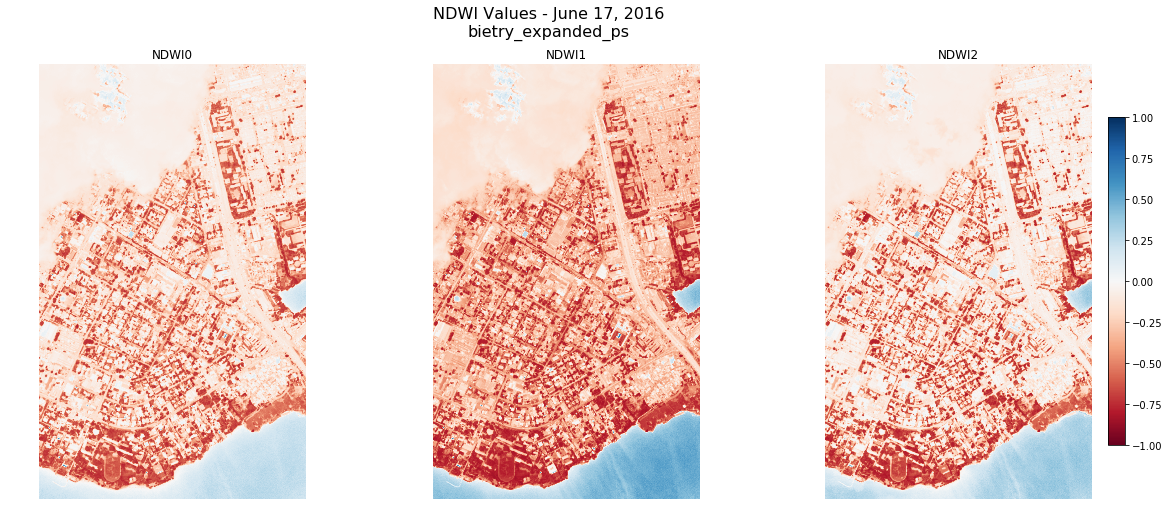

In [14]:
# Plot NDWIs for comparison
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))

plt.suptitle('NDWI Values - June 17, 2016\n'+aoi+"\n", fontsize=16)

ndwi0_plot = ax1.imshow(ndwi0, cmap='RdBu',vmin=-1, vmax=1)
fig.colorbar(ndwi0_plot, fraction=.05)
ax1.set(title="NDWI0")
ax1.set_axis_off()

ndwi1_plot = ax2.imshow(ndwi1, cmap='RdBu',vmin=-1, vmax=1)
ax2.set(title="NDWI1")
ax2.set_axis_off()
                        
ndwi2_plot = ax3.imshow(ndwi2, cmap='RdBu',vmin=-1, vmax=1)
ax3.set(title="NDWI2")
ax3.set_axis_off()

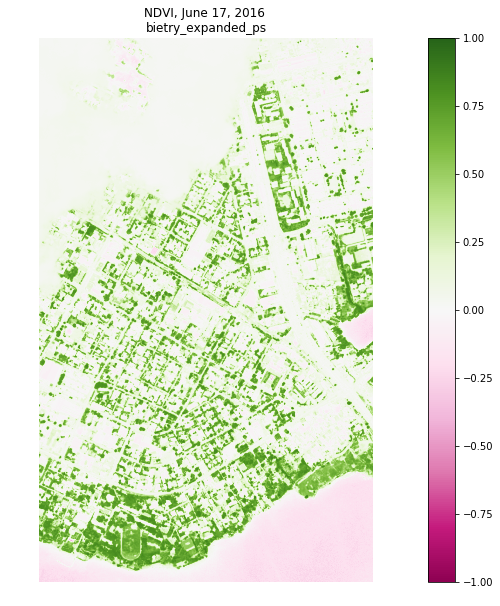

In [15]:
# # Calculate NDVI (NIR1 - R)/(NIR1 + R)
# ndvi = es.normalized_diff(b1=nearir1_scaled, b2= red_scaled) 

# Plot NDVI
fig, ax = plt.subplots(figsize=(20,10))
ndvi_plot = ax.imshow(ndvi, cmap='PiYG',
                vmin=-1, vmax=1)
fig.colorbar(ndvi_plot, fraction=.05)
ax.set(title="NDVI, June 17, 2016 \n" +aoi)
ax.set_axis_off()
plt.show()

In [16]:
# # Plot histogram to explore scaled value distribution 
# fig,ax = plt.subplots()
# plt.hist(dark.ravel());

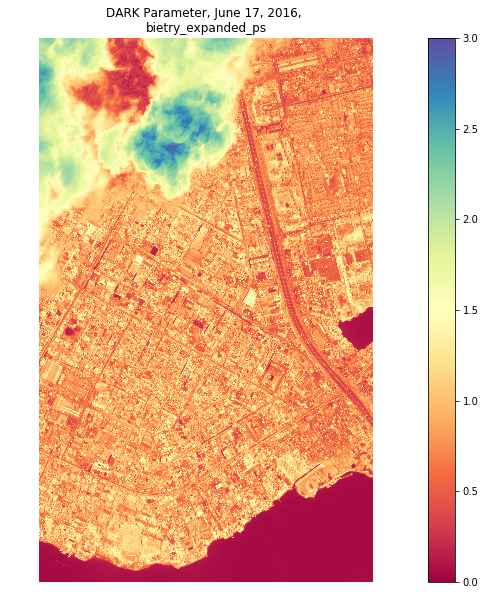

In [17]:
# # Calculate DARK parameter
# dark = (rededge_scaled + nearir1_scaled + nearir2_scaled)

# Plot DARK parameter
fig, ax = plt.subplots(figsize=(20,10))
dark_plot = ax.imshow(dark, cmap='Spectral',
                vmin=0, vmax=3)
fig.colorbar(dark_plot, fraction=.05)
ax.set(title="DARK Parameter, June 17, 2016, \n"+aoi)
ax.set_axis_off()
plt.show()

# Calculate and apply cloud mask

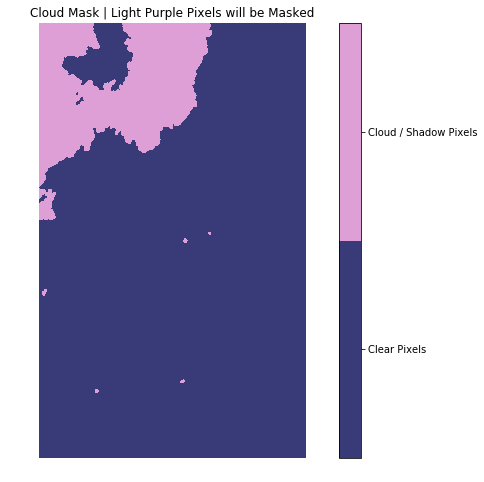

In [18]:
# Calculate and plot cloud mask
cloud_mask = calc_array_mask.define_mask(
    band1=coastal_scaled, band2=rededge_scaled, threshold1=0.25, threshold2=0.25, disk_size=15)

# Plot cloud mask
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(cloud_mask,
               cmap=plt.cm.get_cmap('tab20b', 2))
cbar = fig.colorbar(im)
cbar.set_ticks((0.25, .75))
cbar.ax.set_yticklabels(["Clear Pixels", "Cloud / Shadow Pixels"])
ax.set_title("Cloud Mask | Light Purple Pixels will be Masked")
ax.set_axis_off()
plt.show()

In [19]:
# Apply cloud mask to scaled raster stack
all_bands_cl_free = calc_array_mask.apply_mask(mask_array = cloud_mask, raster_input = all_bands_scaled)

In [20]:
# Define cloud masked scaled bands
coastal_cl_free = all_bands_cl_free[0]
blue_cl_free = all_bands_cl_free[1]
green_cl_free = all_bands_cl_free[2]
yellow_cl_free = all_bands_cl_free[3]
red_cl_free = all_bands_cl_free[4]
rededge_cl_free = all_bands_cl_free[5]
nearir1_cl_free = all_bands_cl_free[6]
nearir2_cl_free = all_bands_cl_free[7]

In [21]:
# Calculated NDWI, NDVI and dark parameter for cloud masked bands
ndwi0_cl_free = es.normalized_diff(b1=green_cl_free, b2=nearir1_cl_free)  
ndwi1_cl_free = es.normalized_diff(b1=coastal_cl_free, b2=nearir2_cl_free)
ndwi2_cl_free = es.normalized_diff(b1= yellow_cl_free, b2=nearir2_cl_free)
ndvi_cl_free = es.normalized_diff(b1=nearir1_cl_free, b2= red_cl_free)
dark_cl_free = rededge_cl_free+nearir1_cl_free+nearir2_cl_free

In [22]:
# Compare mean NDWI valuespre and post cloud mask
mean_ndwi0_cl_free = np.nanmean(ndwi0_cl_free)
mean_ndwi1_cl_free = np.nanmean(ndwi1_cl_free)
mean_ndwi2_cl_free = np.nanmean(ndwi2_cl_free)

print("NDWI0_cl_free:",mean_ndwi0_cl_free, "NDWI1_cl_free:", mean_ndwi1_cl_free, "NDWI2_cl_free:", mean_ndwi2_cl_free)
print("NDWI0:",mean_ndwi0, "NDWI1:", mean_ndwi1, "NDWI2:", mean_ndwi2)

NDWI0_cl_free: -0.21401863 NDWI1_cl_free: -0.29769033 NDWI2_cl_free: -0.18776354
NDWI0: -0.1916559 NDWI1: -0.27321637 NDWI2: -0.17127568


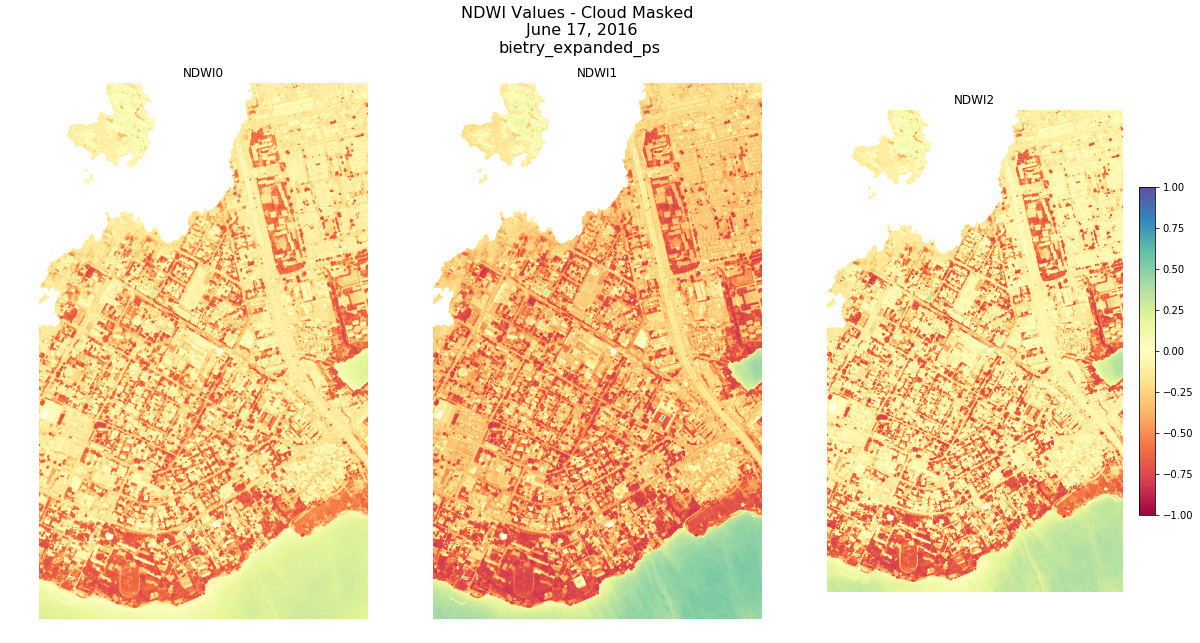

In [23]:
# Plot NDWIs for cloud masked
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

plt.suptitle('NDWI Values - Cloud Masked \n June 17, 2016\n'+aoi, fontsize=16)

ndwi0_cl_free_plot = ax1.imshow(ndwi0_cl_free, cmap='Spectral',vmin=-1, vmax=1)
fig.colorbar(ndwi0_cl_free_plot, fraction=.05)
ax1.set(title="NDWI0")
ax1.set_axis_off()

ndwi1_cl_free_plot = ax2.imshow(ndwi1_cl_free, cmap='Spectral',vmin=-1, vmax=1)
ax2.set(title="NDWI1")
ax2.set_axis_off()
                        
ndwi2_cl_free_plot = ax3.imshow(ndwi2_cl_free, cmap='Spectral',vmin=-1, vmax=1)
ax3.set(title="NDWI2")
ax3.set_axis_off()

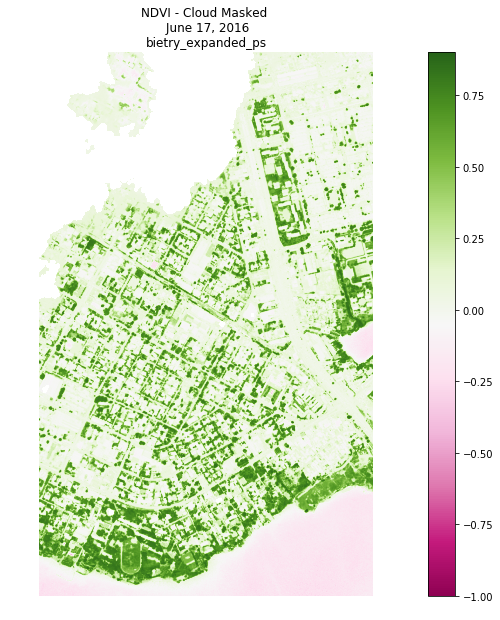

In [24]:
# Plot NDVI parameter
fig, ax = plt.subplots(figsize=(20,10))
ndvi_cl_free_plot = ax.imshow(ndvi_cl_free, cmap='PiYG',
                vmin=-1, vmax=0.9)
fig.colorbar(ndvi_cl_free_plot, fraction=.05)
ax.set(title="NDVI - Cloud Masked \n June 17, 2016\n"+aoi)
ax.set_axis_off()
plt.show()

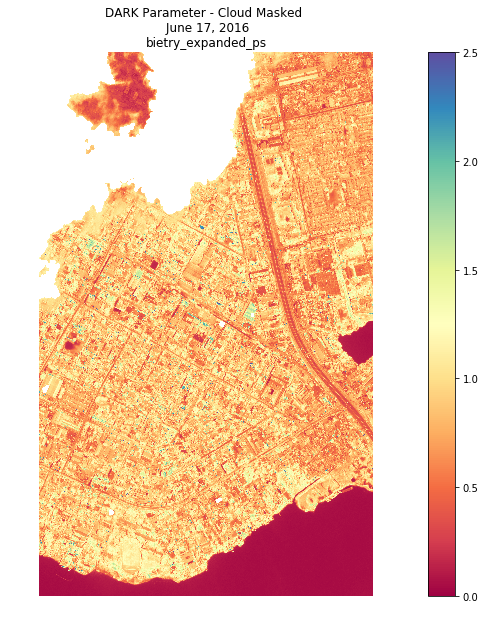

In [25]:
# Plot DARK parameter
fig, ax = plt.subplots(figsize=(20,10))
dark_cl_free_plot = ax.imshow(dark_cl_free, cmap='Spectral',
                vmin=0, vmax=2.5)
fig.colorbar(dark_cl_free_plot, fraction=.05)
ax.set(title="DARK Parameter - Cloud Masked \n June 17, 2016\n"+aoi)
ax.set_axis_off()
plt.show()

In [26]:
# Write out tif files for ndwi, ndvi, dark parameters
with rio.open(outputs_path+'ndwi0_'+aoi+'.tif', 'w', **files_out_meta) as dst:
    dst.write(ndwi0_cl_free, 1)
with rio.open(outputs_path+'ndwi1_'+aoi+'.tif', 'w', **files_out_meta) as dst:
    dst.write(ndwi1_cl_free, 1)
with rio.open(outputs_path+'ndwi2_'+aoi+'.tif', 'w', **files_out_meta) as dst:
    dst.write(ndwi2_cl_free, 1)
with rio.open(outputs_path+'ndvi_'+aoi+'.tif', 'w', **files_out_meta) as dst:
    dst.write(ndvi_cl_free, 1)
with rio.open(outputs_path+'dark_'+aoi+'.tif', 'w', **files_out_meta) as dst:
    dst.write(dark_cl_free, 1)

In [27]:
# print(ndwi1_cl_free.min(), ndwi1_cl_free.max())
# print(dark_cl_free.min(), dark_cl_free.max())
# print(coastal_cl_free.min(), coastal_cl_free.max())
# print(red_cl_free.min(), red_cl_free.max())

### Question for Jeff - where in image are dark values the max. for this subset, dark is always <5

In [28]:
# Calculate parameters for Cloud to Street algorithm
# Flood1 mask is for NDWI1 and Flood2 mask is for NDWI2
flood1_cl_free = ((ndwi1_cl_free >= -0.05) & (dark_cl_free <= 5) & (coastal_cl_free <= 1) & (red_cl_free <= 0.85)).astype(int)
flood2_cl_free = ((ndwi2_cl_free >= 0.03) & (dark_cl_free <= 5.8) & (coastal_cl_free <= 1)).astype(int)

# Combine flood1 and flood 2
flood_combo = np.ma.where(flood1_cl_free==1, 1, np.where(flood2_cl_free==1,1, 0))

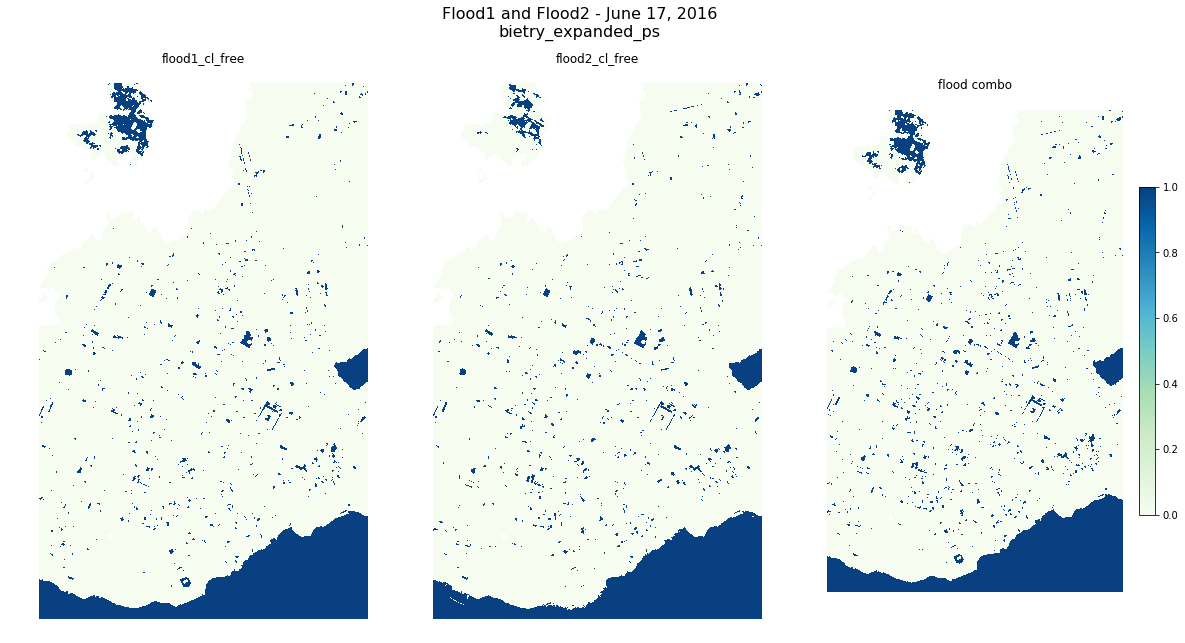

In [29]:
#Plot Flood1, Flood2 and Flood Combo masks
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20, 10))

plt.suptitle('Flood1 and Flood2 - June 17, 2016\n'+aoi+"\n", fontsize=16)

flood1_cl_free_plot = ax1.imshow(flood1_cl_free, cmap='GnBu',vmin=0, vmax=1)
fig.colorbar(flood1_cl_free_plot, fraction=.05)
ax1.set(title="flood1_cl_free\n")
ax1.set_axis_off()

flood2_cl_free_plot = ax2.imshow(flood2_cl_free, cmap='GnBu',vmin=0, vmax=1)
ax2.set(title="flood2_cl_free\n")
ax2.set_axis_off() 

flood_combo_plot = ax3.imshow(flood_combo, cmap='GnBu',vmin=0, vmax=1)
ax3.set(title="flood combo\n")
ax3.set_axis_off() 

In [30]:
# Apply morphological opening to reduce noise for flood combo
flood_mask = morph_indices.smooth_disk(index_array = flood_combo, threshold=1,disk_size=5)

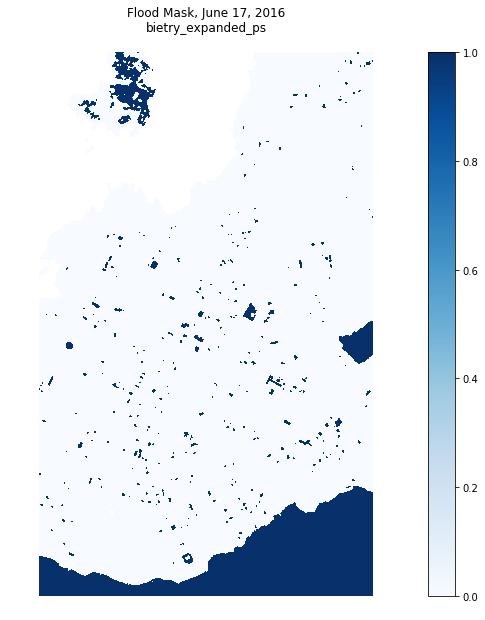

In [31]:
# Plot flood combo mask with noise morphologically removed 
fig, ax = plt.subplots(figsize=(20,10))
flood_opened_plot = ax.imshow(flood_mask, cmap='Blues',
                vmin=0, vmax=1)
fig.colorbar(flood_opened_plot, fraction=.05)
ax.set(title="Flood Mask, June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

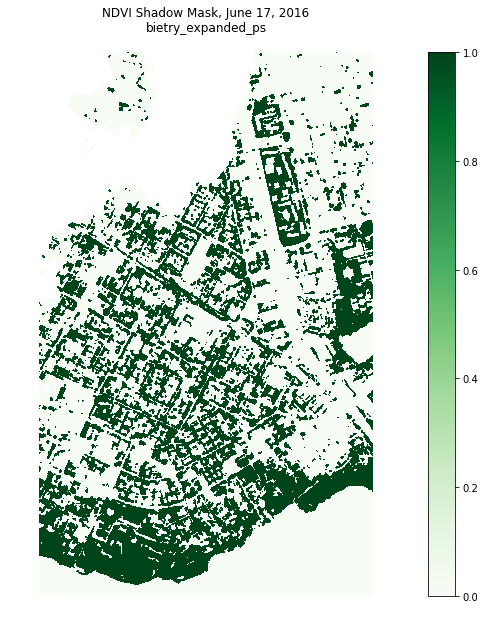

In [32]:
# Develop vegetation mask with noise removed for NDVI  
vegetation_mask = morph_indices.smooth_disk(index_array = ndvi_cl_free,threshold=0.15,disk_size=5)
# Plot shadow mask 
fig, ax = plt.subplots(figsize=(20,10))
test_plot = ax.imshow(vegetation_mask, cmap='Greens',
                vmin=0, vmax=1)
fig.colorbar(test_plot, fraction=.05)
ax.set(title="NDVI Shadow Mask, June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

In [33]:
# Write out flood mask files
with rio.open(outputs_path+'flood1_cl_free_'+aoi+'.tif', 'w', **masks_out_meta) as dst:
    dst.write(flood1_cl_free, 1)
with rio.open(outputs_path+'flood2_cl_free_'+aoi+'.tif', 'w', **masks_out_meta) as dst:
    dst.write(flood2_cl_free, 1)
with rio.open(outputs_path+'flood_combo_cl_free_'+aoi+'.tif', 'w', **masks_out_meta) as dst:
    dst.write(flood_combo, 1)
    
# Write out vegetation mask file
with rio.open(outputs_path+'vegetation_mask_'+aoi+'.tif', 'w', **masks_out_meta) as dst:
    dst.write(vegetation_mask, 1)

9.090906e+19


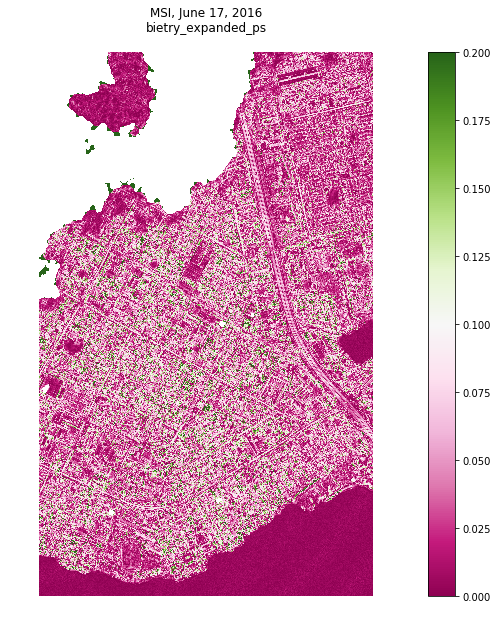

In [34]:
# Calculate MSI
msi = morph_indices.calc_msi(raster_input=all_bands_cl_free, s_min=2, s_max=52, s_delta = 5)
print(msi.max())

# Plot MSI
fig, ax = plt.subplots(figsize=(20,10))
msi_plot = ax.imshow(msi, cmap='PiYG',
                vmin=0, vmax=0.2)
fig.colorbar(msi_plot, fraction=0.05)
ax.set(title="MSI, June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

### *Think about how to handle cloud edge effects. Large max MSI indicates a potential issue*

In [35]:
# # Plot histogram to explore distribution of MSI values
# fig,ax = plt.subplots()
# plt.hist(msi.ravel());

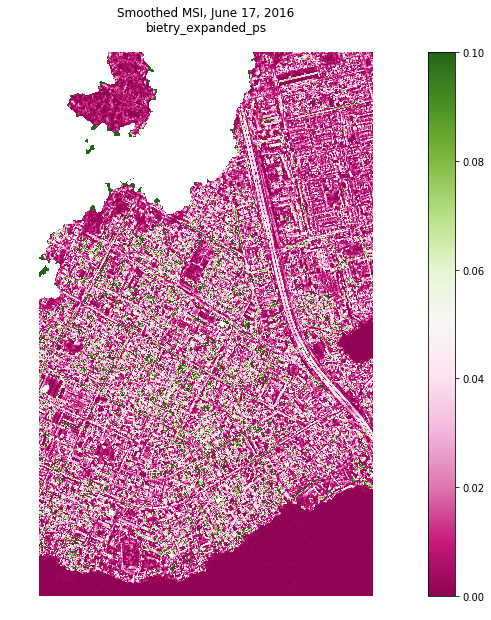

In [36]:
from skimage.morphology import opening, disk
selem_msi = disk(4)
smoothed_msi = opening(msi, selem_msi)

# Plot shadow mask 
fig, ax = plt.subplots(figsize=(20,10))
test_plot = ax.imshow(smoothed_msi, cmap='PiYG',
                vmin=0, vmax=0.1)
fig.colorbar(test_plot, fraction=.05)
ax.set(title="Smoothed MSI, June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

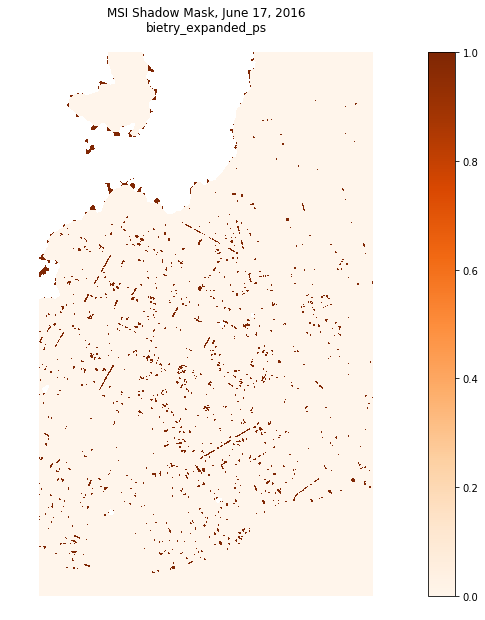

In [37]:
# Develop shadow mask from MSI
shadow_mask = morph_indices.smooth_disk(index_array=msi,threshold=0.08,disk_size=5)

# Plot shadow mask 
fig, ax = plt.subplots(figsize=(20,10))
test_plot = ax.imshow(shadow_mask, cmap='Oranges',
                vmin=0, vmax=1)
fig.colorbar(test_plot, fraction=.05)
ax.set(title="MSI Shadow Mask, June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

In [38]:
# Write out MSI and shadow mask tif file
with rio.open(outputs_path+'msi_shadow_mask_'+aoi+'.tif', 'w', **masks_out_meta) as dst:
    dst.write(shadow_mask, 1)
with rio.open(outputs_path+'msi_'+aoi+'.tif', 'w', **files_out_meta) as dst:
    dst.write(msi, 1)
with rio.open(outputs_path+'msi_smoothed_'+aoi+'.tif', 'w', **files_out_meta) as dst:
    dst.write(smoothed_msi, 1)

# Plot Shadow, Flood and Vegetation Masks

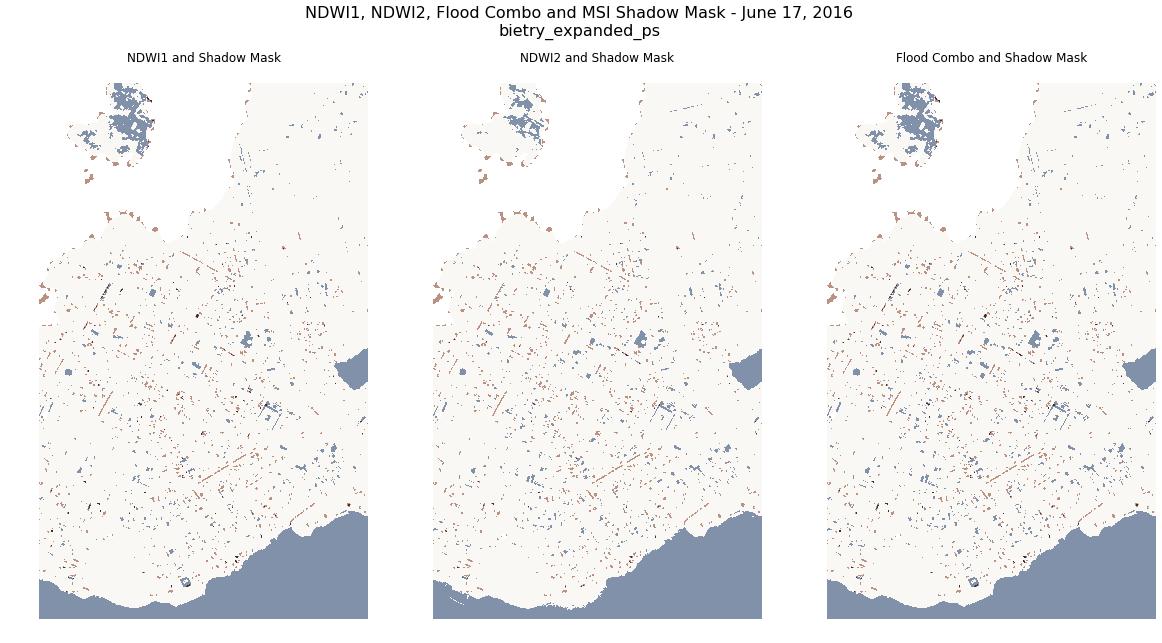

In [39]:
# Compare plots for various flood masks and shadow mask
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20, 10))

plt.suptitle('NDWI1, NDWI2, Flood Combo and MSI Shadow Mask - June 17, 2016\n'+aoi, fontsize=16)

ndwi1_plot = ax1.imshow(ndwi1_cl_free>=-0.05, cmap = 'Blues', vmin = 0, vmax = 1)
msi_plot = ax1.imshow(shadow_mask>=0.12, cmap='Oranges', vmin = 0.00, vmax = 0.1, alpha = .5)
ax1.set(title="NDWI1 and Shadow Mask\n")
ax1.set_axis_off()

ndwi2_plot = ax2.imshow(ndwi2_cl_free>=0.03, cmap = 'Blues', vmin = 0, vmax = 1)
msi_plot = ax2.imshow(shadow_mask>=0.12, cmap='Oranges', vmin = 0.00, vmax = 0.1, alpha = .5)
ax2.set(title="NDWI2 and Shadow Mask\n")
ax2.set_axis_off() 

flood_combo_plot = ax3.imshow(flood_combo>=1, cmap = 'Blues', vmin = 0, vmax = 1)
msi_plot = ax3.imshow(shadow_mask>=0.12, cmap='Oranges', vmin = 0.00, vmax = 0.1, alpha = .5)
ax3.set(title="Flood Combo and Shadow Mask\n")
ax3.set_axis_off()

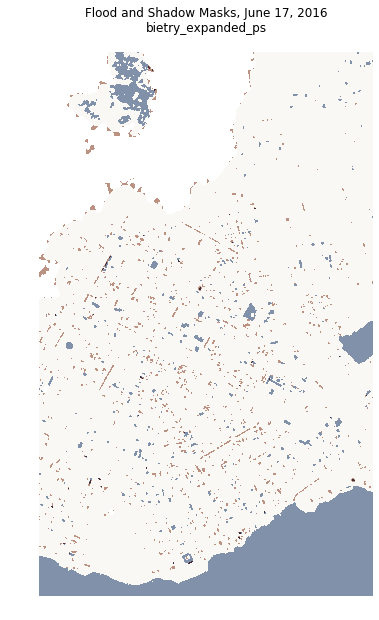

In [40]:
# Plot flood and shadow masks
fig, ax = plt.subplots(figsize=(20,10))
flood_plot = ax.imshow(flood_mask==1, cmap = 'Blues', vmin = 0, vmax = 1)
shadow_plot = ax.imshow(shadow_mask==1, cmap='Oranges', vmin = 0.00, vmax = 1, alpha = .5)

ax.set(title="Flood and Shadow Masks, June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

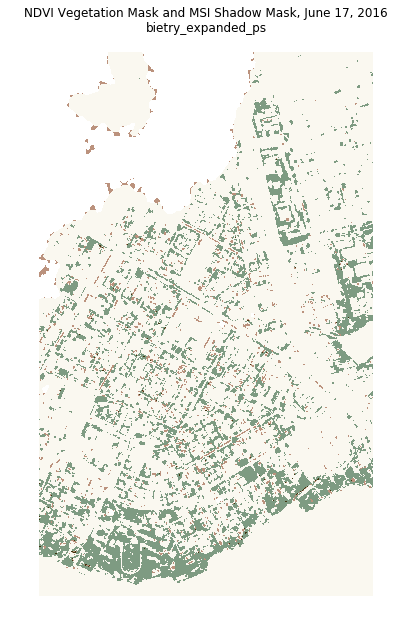

In [41]:
# Plot vegetation and shadow masks
fig, ax = plt.subplots(figsize=(20,10))
ndvi_plot = ax.imshow(ndvi_cl_free>.5, cmap = 'Greens')
msi_plot = ax.imshow(shadow_mask>=1, cmap='Oranges',alpha = .5)

ax.set(title="NDVI Vegetation Mask and MSI Shadow Mask, June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

# Calculate NDWI "optimal" - MSI from Xie et al (2016)

In [42]:
# Calculate optimal NDWI values and subtract MSI 
ndwi_coastal = es.normalized_diff(b1=coastal_cl_free, b2 = nearir2_cl_free)
ndwi_green = es.normalized_diff(b1=green_cl_free, b2 = nearir2_cl_free)
ndwi_coastal_msi = ndwi_coastal - msi
ndwi_green_msi = ndwi_green - msi

In [43]:
# Write out files
with rio.open(outputs_path+'ndwi_green_'+aoi+'.tif', 'w', **files_out_meta) as dst:
    dst.write(ndwi_green, 1)
with rio.open(outputs_path+'ndwi_coastal_'+aoi+'.tif', 'w', **files_out_meta) as dst:
    dst.write(ndwi_coastal, 1)
with rio.open(outputs_path+'ndwi_green_msi_'+aoi+'.tif', 'w', **files_out_meta) as dst:
    dst.write(ndwi_green_msi, 1)
with rio.open(outputs_path+'ndwi_costal_msi_'+aoi+'.tif', 'w', **files_out_meta) as dst:
    dst.write(ndwi_coastal_msi, 1)

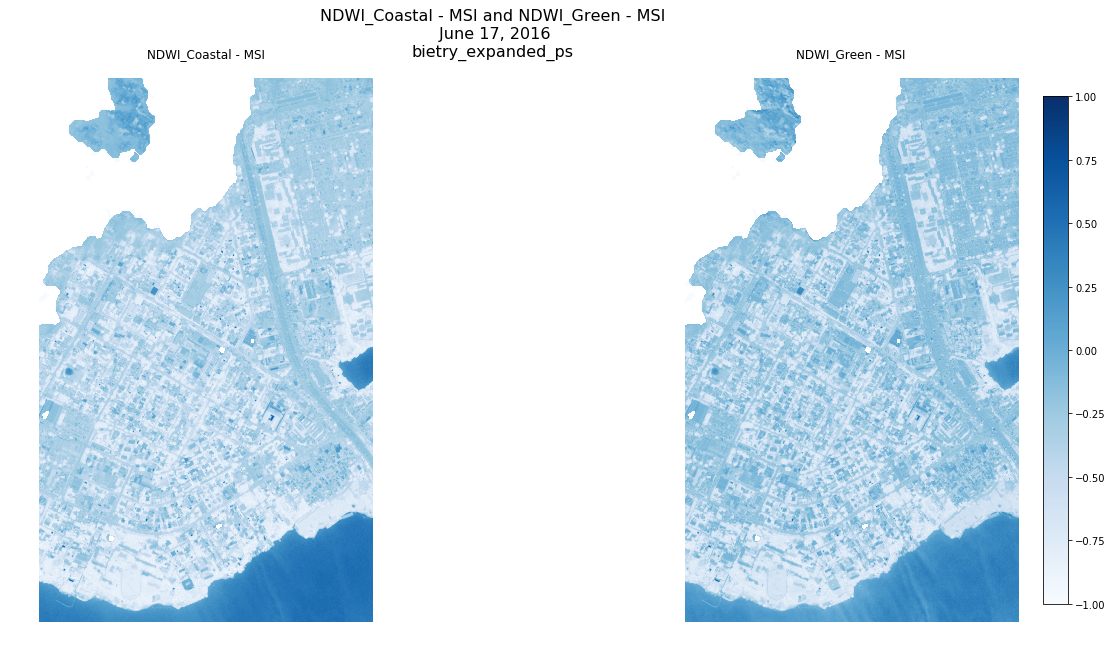

In [44]:
# Compare plots for NDWI_Coastal - MSI and NDWI_Green - MSI
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

plt.suptitle('NDWI_Coastal - MSI and NDWI_Green - MSI\n June 17, 2016\n'+aoi+"\n", fontsize=16)

ndwi_coastal_plot = ax1.imshow(ndwi_coastal_msi, cmap = 'Blues', vmin = -1, vmax = 1)
ax1.set(title="NDWI_Coastal - MSI\n")
ax1.set_axis_off()

ndwi_green_plot = ax2.imshow(ndwi_green_msi, cmap = 'Blues', vmin = -1, vmax = 1)
ax2.set(title="NDWI_Green - MSI\n")
ax2.set_axis_off()

fig.colorbar(ndwi_coastal_plot, fraction=.05)
plt.show()

In [45]:
# Create flood masks based on thresholds
ndwi_coastal_msi_mask = (ndwi_coastal_msi>0).astype(int)
ndwi_green_msi_mask = (ndwi_green_msi>0).astype(int)

# Create flood masks and remove noise 
ndwi_coastal_msi_mask_smoothed = morph_indices.smooth_disk(index_array=ndwi_coastal_msi,threshold=0.01,disk_size=4)
ndwi_green_msi_mask_smoothed = morph_indices.smooth_disk(index_array=ndwi_green_msi,threshold=0.01,disk_size=4)

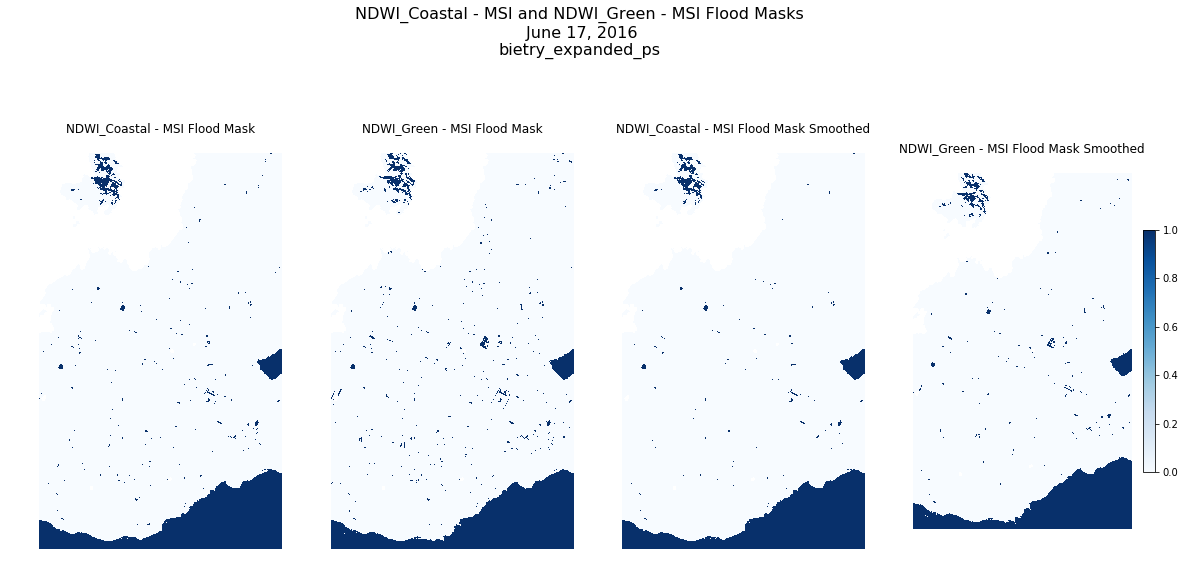

In [46]:
# Compare plots for masks
fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4, figsize=(20, 10))

plt.suptitle('NDWI_Coastal - MSI and NDWI_Green - MSI Flood Masks\n June 17, 2016\n'+aoi, fontsize=16)

ndwi_coastal_mask_plot = ax1.imshow(ndwi_coastal_msi_mask, cmap = 'Blues', vmin = 0, vmax = 1)
ax1.set(title="NDWI_Coastal - MSI Flood Mask\n")
ax1.set_axis_off()

ndwi_green_mask_plot = ax2.imshow(ndwi_green_msi_mask, cmap = 'Blues', vmin = 0, vmax = 1)
ax2.set(title="NDWI_Green - MSI Flood Mask\n")
ax2.set_axis_off()

ndwi_coastal_mask_plot = ax3.imshow(ndwi_coastal_msi_mask_smoothed, cmap = 'Blues', vmin = 0, vmax = 1)
ax3.set(title="NDWI_Coastal - MSI Flood Mask Smoothed\n")
ax3.set_axis_off()

ndwi_green_mask_plot = ax4.imshow(ndwi_green_msi_mask_smoothed, cmap = 'Blues', vmin = 0, vmax = 1)
ax4.set(title="NDWI_Green - MSI Flood Mask Smoothed\n")
ax4.set_axis_off()


fig.colorbar(ndwi_coastal_mask_plot, fraction=.05)
plt.show()

# Calculate MBI 

0.8315


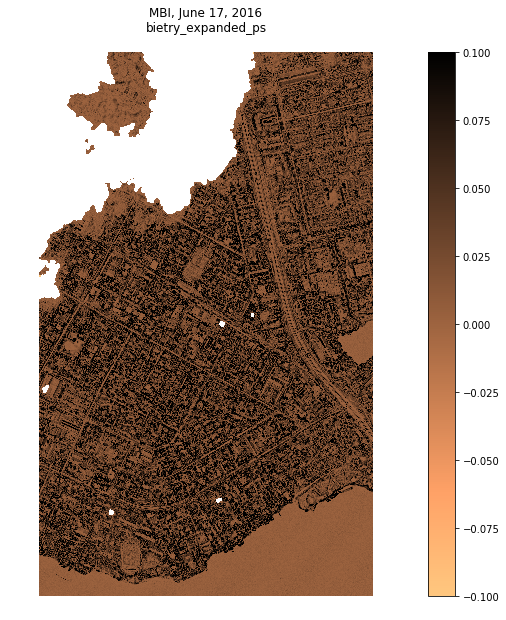

In [47]:
# Calculate MBI
mbi = morph_indices.calc_mbi(raster_input=all_bands_cl_free,s_min=2, s_max=52,s_delta=5)
print(mbi.max())

# Plot MBI
fig, ax = plt.subplots(figsize=(20,10))
mbi_plot = ax.imshow(mbi, cmap='copper_r',
                vmin=0, vmax=0)
fig.colorbar(mbi_plot, fraction=0.05)
ax.set(title="MBI, June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

In [48]:
# Plot histogram to explore distribution of MSI values
# fig,ax = plt.subplots()
# plt.hist(mbi.ravel());

In [49]:
# Develop building mask for MBI > 0.1 and apply morphological opening
from skimage.morphology import opening, disk

building = (mbi>=0.065).astype(int)
selem_building = disk(1)
building_opened = opening(building, selem_building)

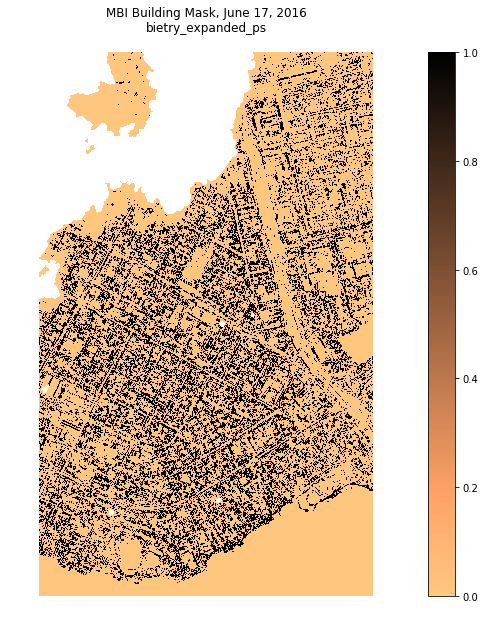

In [50]:
# Develop shadow mask for MBI > 0.1 and apply morphological opening
building_mask = morph_indices.smooth_disk(index_array=mbi,threshold=0.05,disk_size=2)

# Plot building mask layer 
fig, ax = plt.subplots(figsize=(20,10))
building_plot = ax.imshow(building_mask, cmap='copper_r',
                vmin=0, vmax=1)
fig.colorbar(building_plot, fraction=.05)
ax.set(title="MBI Building Mask, June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

In [51]:
# Write out MBI and building mask files
with rio.open(outputs_path+'mbi_'+aoi+'.tif', 'w', **files_out_meta) as dst:
    dst.write(mbi, 1)
with rio.open(outputs_path+'building_mask_'+aoi+'.tif', 'w', **masks_out_meta) as dst:
    dst.write(building_mask, 1)

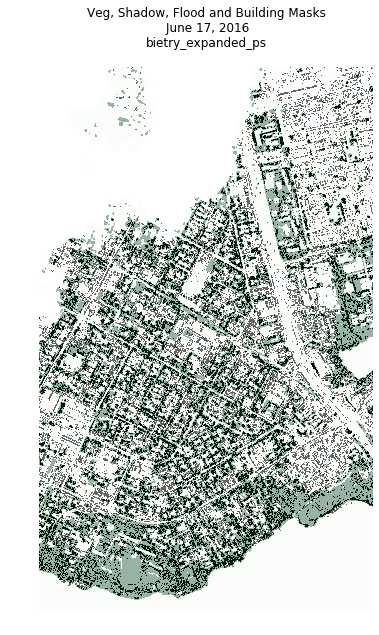

In [52]:
# Plot vegetation and building masks
fig, ax = plt.subplots(figsize=(20,10))
ndvi_plot = ax.imshow(vegetation_mask==1, cmap = 'Greens')
mbi_plot = ax.imshow(building_mask==1, cmap='Greys',alpha = 0.6)
# msi_plot = ax.imshow(shadow_mask==1, cmap='Oranges',alpha=0.5)
# flood_plots = ax.imshow(flood_mask==1, cmap='Blues', alpha=0.5)

ax.set(title="Veg, Shadow, Flood and Building Masks\n June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

Trial using SDI from Shahi et al. 2014. *A Novel Spectral Index for Automatic Shadow Detection in Urban Mapping Based On  WorldView-2 Satellite Imagery.* World Academy of Science, Engineering and Technology International Journal of Environmental and Ecological Engineering Vol:8, No:10.

In [53]:
sdi = ((nearir2_scaled-blue_cl_free)/(nearir2_cl_free+blue_cl_free))-nearir1_cl_free
print(sdi.max())

0.64638215


In [54]:
# Plot histogram to explore distribution of MSI values
# fig,ax = plt.subplots()
# plt.hist(sdi.ravel());

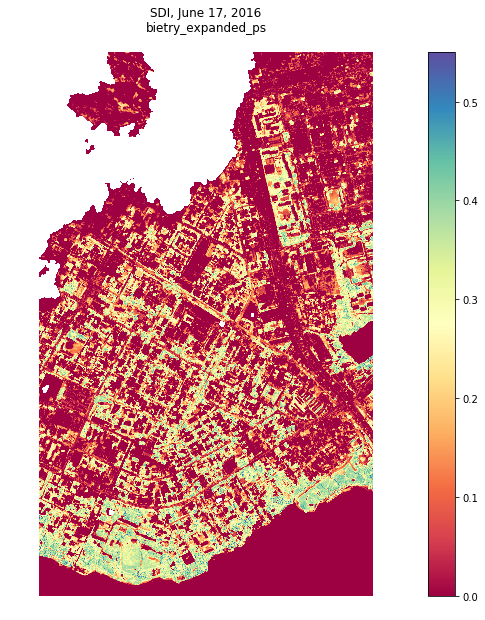

In [55]:
# Plot SDI
fig, ax = plt.subplots(figsize=(20,10))
sdi_plot = ax.imshow(sdi, cmap='Spectral',
                vmin=0, vmax=.55)
fig.colorbar(sdi_plot, fraction=.05)
ax.set(title="SDI, June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

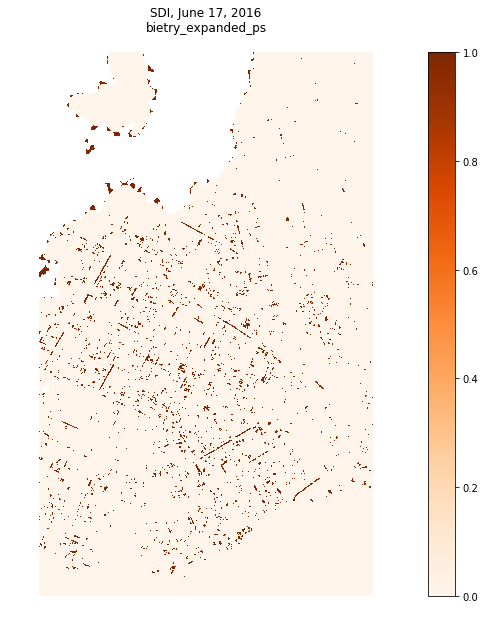

In [56]:
# Develop shadow mask for SDI and apply morphological opening to remove noise
sdi_mask = morph_indices.smooth_disk(index_array=msi,threshold=0.09,disk_size=4)

# Plot SDI mask
fig, ax = plt.subplots(figsize=(20,10))
sdi_plot = ax.imshow(sdi_mask, cmap='Oranges',
                vmin=0, vmax=1)
fig.colorbar(sdi_plot, fraction=.05)
ax.set(title="SDI, June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

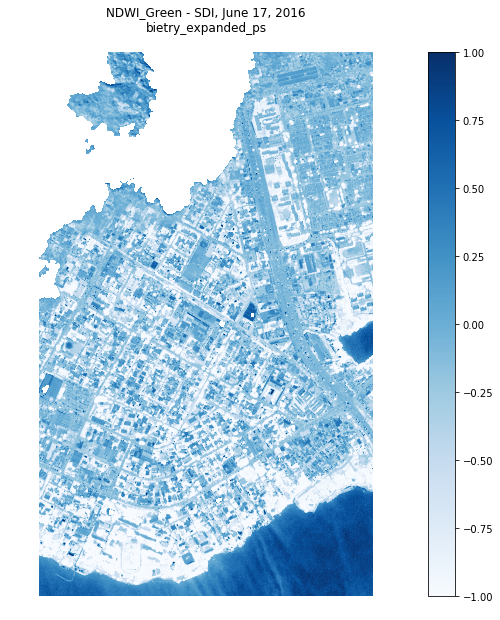

In [57]:
flood_sdi = ndwi_green-sdi
# Plot ndwi_green - sdi
fig, ax = plt.subplots(figsize=(20,10))
sdi_plot = ax.imshow(flood_sdi, cmap='Blues',
                vmin=-1, vmax=1)
fig.colorbar(sdi_plot, fraction=.05)
ax.set(title="NDWI_Green - SDI, June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

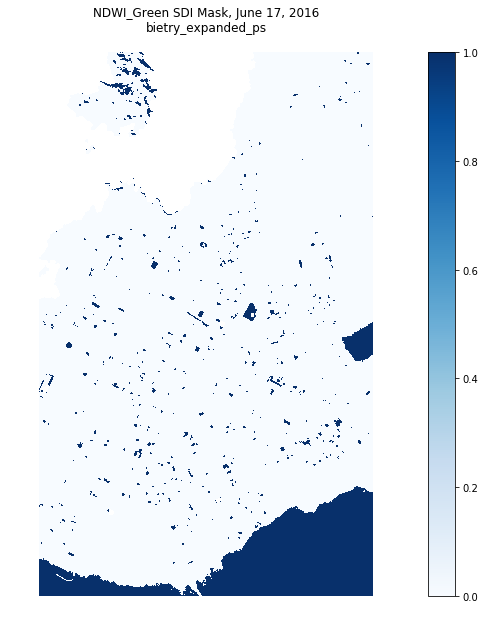

In [58]:
ndwi_green_sdi_mask_smoothed = morph_indices.smooth_disk(index_array=flood_sdi,threshold=0.25,disk_size=4)
# Plot SDI mask
fig, ax = plt.subplots(figsize=(20,10))
sdi_plot = ax.imshow(ndwi_green_sdi_mask_smoothed, cmap='Blues',
                vmin=0, vmax=1)
fig.colorbar(sdi_plot, fraction=.05)
ax.set(title="NDWI_Green SDI Mask, June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()